#  Titanic - Machine Learning from Disaster
### The objective of this lab is to apply machine learning techniques to the Titanic dataset to predict passenger survival

In [550]:
# importing necessary libraries
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report,recall_score, precision_score, f1_score
import seaborn as sns
from sklearn.impute import SimpleImputer
import warnings
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPClassifier
import matplotlib.pyplot as plt
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB


warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=UserWarning)

In [551]:
def wrangle(filepath):
    """
    This function reads a CSV file containing Titanic passenger data, performs data cleaning and feature engineering,
    and returns a processed DataFrame.

    Parameters:
    filepath (str): The path to the CSV file containing the Titanic passenger data.

    Returns:
    pandas.DataFrame: A DataFrame with the following columns: 'PassengerId', 'Survived', 'Pclass', 'Sex', 'Age', 'Fare', 'Family'.
    The 'Family' column is created by summing 'SibSp' and 'Parch' columns.
    Missing values in the 'Age' column are filled with the median value.
    """
    # Import CSV
    df = pd.read_csv(filepath)
    
    # Drop columns
    df = df.drop(columns=['Name', 'Ticket', 'Cabin','PassengerId'])
    
    # feature creation
    df['Family'] = df['SibSp'] + df['Parch']
    
    # Drop columns
    df = df.drop(columns=['SibSp', 'Parch'])
    
    # Create an imputer object with a strategy to fill missing values with the median
    imputer = SimpleImputer(strategy='median')
    df['Age'] = imputer.fit_transform(df[['Age']])
    df['Age'] = df['Age'].astype(int)
    
    return df

    

## Task 1: Data Exploration and Visualization

In [552]:
# Load the train dataset
train_data = wrangle("titanic_data/train.csv")
train_data.head(10)

Pclass     Sex  Age      Fare Embarked  Survived  Family
0       3    male   28   56.4958        S         1       0
1       2    male   28    0.0000        S         0       0
2       1    male   28  221.7792        S         0       0
3       3  female   18    9.3500        S         1       1
4       2  female   31   26.2500        S         1       2
5       3    male   21    8.4333        S         0       0
6       3    male   26   56.4958        S         1       0
7       1    male   28  227.5250        C         0       0
8       3    male   28    7.7500        Q         1       0
9       3  female   31   18.0000        S         0       1

In [553]:
# Viewing the statistical values of the training data
train_data.describe(include="all")

Pclass   Sex         Age        Fare Embarked    Survived  \
count   712.000000   712  712.000000  712.000000      710  712.000000   
unique         NaN     2         NaN         NaN        3         NaN   
top            NaN  male         NaN         NaN        S         NaN   
freq           NaN   459         NaN         NaN      516         NaN   
mean      2.308989   NaN   29.443820   31.819826      NaN    0.383427   
std       0.833563   NaN   13.043029   48.059104      NaN    0.486563   
min       1.000000   NaN    0.000000    0.000000      NaN    0.000000   
25%       2.000000   NaN   22.000000    7.895800      NaN    0.000000   
50%       3.000000   NaN   28.000000   14.454200      NaN    0.000000   
75%       3.000000   NaN   36.000000   31.000000      NaN    1.000000   
max       3.000000   NaN   80.000000  512.329200      NaN    1.000000   

            Family  
count   712.000000  
unique         NaN  
top            NaN  
freq           NaN  
mean      0.883427  
std       1.589047  
min       0.000000  
25%       0.000000  
50%       0.000000  
75%       1.000000  
max      10.000000

In [554]:
# View the data types and non-null count of the training data
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 712 entries, 0 to 711
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Pclass    712 non-null    int64  
 1   Sex       712 non-null    object 
 2   Age       712 non-null    int32  
 3   Fare      712 non-null    float64
 4   Embarked  710 non-null    object 
 5   Survived  712 non-null    int64  
 6   Family    712 non-null    int64  
dtypes: float64(1), int32(1), int64(3), object(2)
memory usage: 36.3+ KB


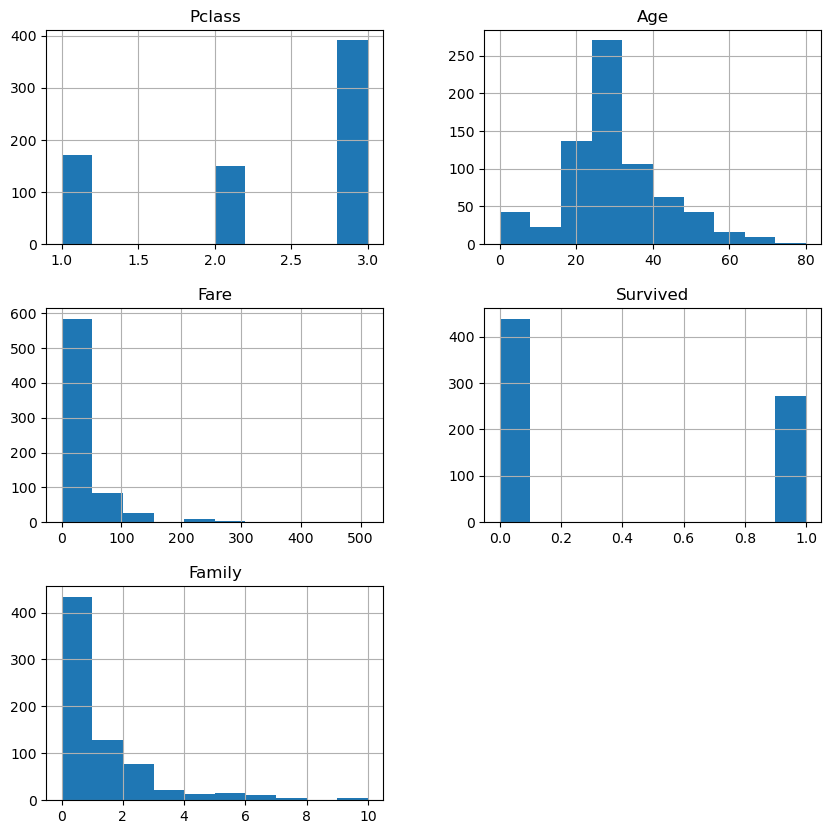

In [555]:
# Visualizing the distribution of the training data
train_data.hist(figsize=(10,10));

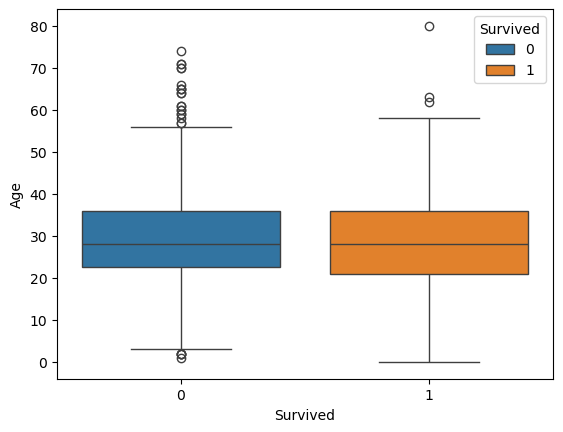

In [556]:
# Visualizing the relationships between the age and the survived column
sns.boxplot(x ='Survived',y='Age',hue='Survived', data=train_data);

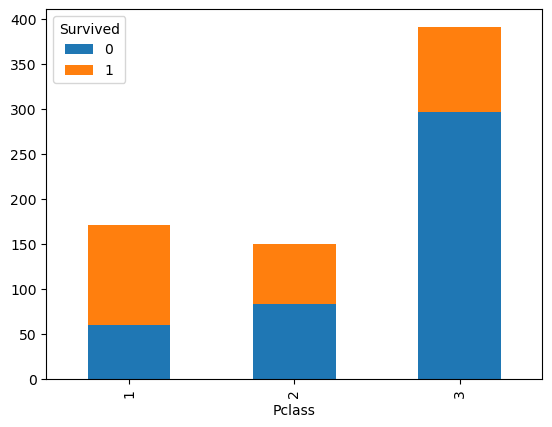

In [557]:
# Visualizing the relationships between the class and the survived column
crosstab = pd.crosstab(train_data['Pclass'], train_data['Survived'])

# Plot the stacked bar plot
crosstab.plot(kind='bar', stacked=True)
plt.show()

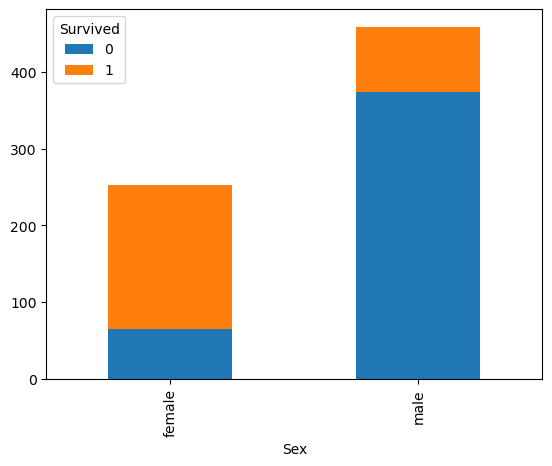

In [558]:
# Visualizing the relationships between the gender and the survived column
# Create a cross-tabulation
crosstab = pd.crosstab(train_data['Sex'], train_data['Survived'])

# Plot the stacked bar plot
crosstab.plot(kind='bar', stacked=True)
plt.show()


## Task 2: Data Cleaning and Preprocessing

In [559]:
# Checking for missing data
train_data.isnull().sum()

Pclass      0
Sex         0
Age         0
Fare        0
Embarked    2
Survived    0
Family      0
dtype: int64

In [560]:
# Fill null values in the 'Embarked' column with the mode
train_data['Embarked'].fillna(train_data['Embarked'].mode()[0], inplace=True)

In [561]:
# Instantiate a label encoder object
le = LabelEncoder()

In [562]:
# Encoding object data types in train_data
for col in train_data.select_dtypes('object'):
    train_data[col] = le.fit_transform(train_data[col])

In [563]:
# Spilt the train data to features and target
X = train_data.drop(columns=['Survived'])
y = train_data['Survived']

In [564]:
# Instantiate the standard scaler 
scaler = StandardScaler()

In [565]:
# Applying Standardization to the features
X = scaler.fit_transform(X)

In [566]:
# Splitting the train data into train and validation sets
X_train,X_val,y_train,y_val = train_test_split(X,y,test_size=0.2,random_state=42)

## Task 3: Feature Engineering 

In [567]:
# Pearson correlation matrix on training data
corr = train_data.corr(method='pearson')

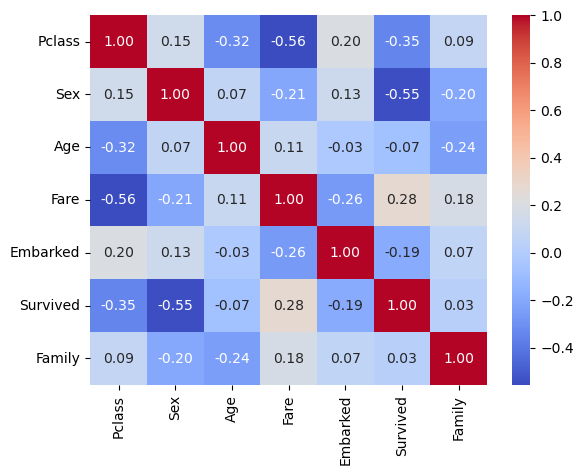

In [568]:
# Plot a heatmap of the correlation matrix
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f");

## Task 4: Model Selection and Training

In [569]:
# Create a pipeline with an imputer, scaler, and the model
pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler()),
    
    #('model', RandomForestClassifier(random_state=42)) # RandomForestClassifier accuracy: 0.77
    
    #('model', SVC()) # Support Vector Machine accuracy: 0.80
    
    # ('model', LogisticRegression()) # Logistic Regression accuracy: 0.77
    
    #('model', KNeighborsClassifier()) # KNeighborsClassifier accuracy: 0.78
    
    #('model', GradientBoostingClassifier(random_state=42)) # GradientBoostingClassifier accuracy: 0.77

    ('model', MLPClassifier(solver='lbfgs', alpha=1e-5,hidden_layer_sizes=(5, 2), random_state=1))

    # ('model', DecisionTreeClassifier(random_state=42)) # DecisionTreeClassifier accuracy: 0.76

    #('model', SGDClassifier(loss="hinge", penalty="l2", max_iter=5))

    #('model', GaussianNB()) # GaussianNB accuracy: 0.77
    
])


In [570]:
# Fit the pipeline on the training data
pipeline.fit(X_train, y_train)

Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                ('scaler', StandardScaler()),
                ('model',
                 MLPClassifier(alpha=1e-05, hidden_layer_sizes=(5, 2),
                               random_state=1, solver='lbfgs'))])

In [571]:
# Evaluate the pipeline on the test data
pipeline.score(X_val, y_val)

0.7692307692307693

In [572]:
# Making predictions on the validation data
y_pred = pipeline.predict(X_val)

In [573]:
# Printing the confusion matrix
conf = confusion_matrix(y_val, y_pred)
print(conf)

[[77  7]
 [26 33]]


In [574]:
# Extracting TP, TN, FP, FN from the confusion matrix
tn, fp, fn, tp = conf.ravel()

print(f"True Positives (TP): {tp}")
print(f"True Negatives (TN): {tn}")
print(f"False Positives (FP): {fp}")
print(f"False Negatives (FN): {fn}")

True Positives (TP): 33
True Negatives (TN): 77
False Positives (FP): 7
False Negatives (FN): 26


In [575]:
# Perform cross-validation
cv_scores = cross_val_score(pipeline, X_train, y_train, cv=5, scoring='accuracy')

# Print the cross-validation scores and the mean score
print("Cross-validation scores:", cv_scores)
print("Mean cross-validation score:", cv_scores.mean())

Cross-validation scores: [0.74561404 0.81578947 0.84210526 0.81578947 0.85840708]
Mean cross-validation score: 0.8155410650520105


In [576]:
report = classification_report(y_val, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.75      0.92      0.82        84
           1       0.82      0.56      0.67        59

    accuracy                           0.77       143
   macro avg       0.79      0.74      0.75       143
weighted avg       0.78      0.77      0.76       143



In [577]:
print("Accuracy:", round(accuracy_score(y_val, y_pred),2))

Accuracy: 0.77


In [578]:
print("Recall score:", round(recall_score(y_val, y_pred),2))

Recall score: 0.56


In [579]:
print("Precision score:", round(precision_score(y_val, y_pred),2))

Precision score: 0.82


## Task 5: Model Optimization 

In [580]:
# # Define the parameter grid for SGDClassifier
# param_grid_sgd = {
#     'model__loss': ['hinge', 'log', 'modified_huber'],
#     'model__penalty': ['l2', 'l1', 'elasticnet'],
#     'model__alpha': [0.0001, 0.001, 0.01, 0.1],
#     'model__max_iter': [1000, 2000, 3000],
#     'model__tol': [1e-3, 1e-4, 1e-5]
# }

# # Update the pipeline with SGDClassifier
# pipeline.set_params(model=SGDClassifier(random_state=42))

# # Instantiate the GridSearchCV object
# grid_search_sgd = GridSearchCV(pipeline, param_grid_sgd, cv=5, scoring='accuracy')

# # Fit the grid search to the training data
# grid_search_sgd.fit(X_train, y_train)

# # Get the best parameters and best score
# best_params_sgd = grid_search_sgd.best_params_
# best_score_sgd = grid_search_sgd.best_score_

# print("Best Parameters for SGDClassifier:", best_params_sgd)
# print("Best Cross-Validation Score for SGDClassifier:", best_score_sgd)

In [581]:
# # Define the parameter grid for GradientBoostingClassifier
# param_grid_gb = {
#     'model__n_estimators': [50, 100, 200],
#     'model__learning_rate': [0.01, 0.1, 0.2],
#     'model__max_depth': [3, 4, 5],
#     'model__min_samples_split': [2, 5, 10],
#     'model__min_samples_leaf': [1, 2, 4]
# }

# # Update the pipeline with GradientBoostingClassifier
# pipeline.set_params(model=GradientBoostingClassifier(random_state=42))

# # Instantiate the GridSearchCV object
# grid_search_gb = GridSearchCV(pipeline, param_grid_gb, cv=5, scoring='accuracy')

# # Fit the grid search to the training data
# grid_search_gb.fit(X_train, y_train)

# # Get the best parameters and best score
# best_params_gb = grid_search_gb.best_params_
# best_score_gb = grid_search_gb.best_score_

# print("Best Parameters for GradientBoostingClassifier:", best_params_gb)
# print("Best Cross-Validation Score for GradientBoostingClassifier:", best_score_gb)

In [582]:
# # Define the parameter grid for GaussianNB
# param_grid_gnb = {
#     'model__var_smoothing': np.logspace(0, -9, num=100)
# }

# # Update the pipeline with GaussianNB
# pipeline.set_params(model=GaussianNB())

# # Instantiate the GridSearchCV object
# grid_search_gnb = GridSearchCV(pipeline, param_grid_gnb, cv=5, scoring='accuracy')

# # Fit the grid search to the training data
# grid_search_gnb.fit(X_train, y_train)

# # Get the best parameters and best score
# best_params_gnb = grid_search_gnb.best_params_
# best_score_gnb = grid_search_gnb.best_score_

# print("Best Parameters for GaussianNB:", best_params_gnb)
# print("Best Cross-Validation Score for GaussianNB:", best_score_gnb)

In [583]:
# Define the parameter grid for MLPClassifier
param_grid_mlp = {
    'model__hidden_layer_sizes': [(50,), (100,), (50, 50)],
    'model__activation': ['tanh', 'relu'],
    'model__solver': ['sgd', 'adam'],
    'model__alpha': [0.0001, 0.05],
    'model__learning_rate': ['constant', 'adaptive'],
}

# Update the pipeline with MLPClassifier
pipeline.set_params(model=MLPClassifier(random_state=42))

# Instantiate the GridSearchCV object
grid_search_mlp = GridSearchCV(pipeline, param_grid_mlp, cv=5, scoring='accuracy')

# Fit the grid search to the training data
grid_search_mlp.fit(X_train, y_train)

# Get the best parameters and best score
best_params_mlp = grid_search_mlp.best_params_
best_score_mlp = grid_search_mlp.best_score_

print("Best Parameters for MLPClassifier:", best_params_mlp)
print("Best Cross-Validation Score for MLPClassifier:", best_score_mlp)

Best Parameters for MLPClassifier: {'model__activation': 'relu', 'model__alpha': 0.0001, 'model__hidden_layer_sizes': (100,), 'model__learning_rate': 'constant', 'model__solver': 'adam'}
Best Cross-Validation Score for MLPClassifier: 0.8261139574600218


In [584]:
# # Define the parameter grid for DecisionTreeClassifier
# param_grid_dt = {
#     'model__max_depth': [3, 4, 5, 6, 7, 8, 9, 10],
#     'model__min_samples_split': [2, 5, 10, 20],
#     'model__min_samples_leaf': [1, 2, 4, 8]
# }

# # Update the pipeline with DecisionTreeClassifier
# pipeline.set_params(model=DecisionTreeClassifier(random_state=42))

# # Instantiate the GridSearchCV object
# grid_search_dt = GridSearchCV(pipeline, param_grid_dt, cv=5, scoring='accuracy')

# # Fit the grid search to the training data
# grid_search_dt.fit(X_train, y_train)

# # Get the best parameters and best score
# best_params_dt = grid_search_dt.best_params_
# best_score_dt = grid_search_dt.best_score_

# print("Best Parameters for DecisionTreeClassifier:", best_params_dt)
# print("Best Cross-Validation Score for DecisionTreeClassifier:", best_score_dt)

In [585]:
# # Define the parameter grid for RandomForestClassifier
# param_grid_rf = {
#     'model__n_estimators': [50, 100, 200],
#     'model__max_depth': [3, 4, 5],
#     'model__min_samples_split': [2, 5, 10],
#     'model__min_samples_leaf': [1, 2, 4]
# }

# # Update the pipeline with RandomForestClassifier
# pipeline.set_params(model=RandomForestClassifier(random_state=42))

# # Instantiate the GridSearchCV object
# grid_search_rf = GridSearchCV(pipeline, param_grid_rf, cv=5, scoring='accuracy')

# # Fit the grid search to the training data
# grid_search_rf.fit(X_train, y_train)

# # Get the best parameters and best score
# best_params_rf = grid_search_rf.best_params_
# best_score_rf = grid_search_rf.best_score_

# print("Best Parameters for RandomForestClassifier:", best_params_rf)
# print("Best Cross-Validation Score for RandomForestClassifier:", best_score_rf)

In [586]:
# Update the pipeline with the best parameter 
pipeline.set_params(**best_params_mlp)

# Fit the updated pipeline on the training data
pipeline.fit(X_train, y_train)

# Make predictions on the validation set
y_pred = pipeline.predict(X_val)

# Evaluate the updated pipeline
accuracy = accuracy_score(y_val, y_pred)
print("Accuracy after tuning :", round(accuracy,2))

# Print the precision, recall, and f1-score
print("Precision after tuning:", round(precision_score(y_val, y_pred),2))
print("Recall after tuning:", round(recall_score(y_val, y_pred),2))
print("F1 Score after tuning:", round(f1_score(y_val, y_pred),2))

Accuracy after tuning : 0.8
Precision after tuning: 0.84
Recall after tuning: 0.63
F1 Score after tuning: 0.72


## Task 6: Testing and Submission

In [587]:
# Importing the test data 
test_data = wrangle("titanic_data/test.csv")
test_data.head(10)

Pclass     Sex  Age      Fare Embarked  Family
0       3    male   24   24.1500        S       2
1       3    male   44   16.1000        S       1
2       3    male   22    7.2250        C       0
3       3    male   41   14.1083        S       2
4       3  female   27   15.5000        Q       1
5       3  female   36   17.4000        S       1
6       2  female   36   13.0000        S       0
7       1    male   45   26.5500        S       0
8       1    male   49  110.8833        C       2
9       2    male   34   26.0000        S       1

In [588]:
# Checking for missing data in the test data
test_data.isnull().sum()

Pclass      0
Sex         0
Age         0
Fare        0
Embarked    0
Family      0
dtype: int64

In [589]:
# Encoding object data types in test_data
for col in test_data.select_dtypes('object'):
    test_data[col] = le.fit_transform(test_data[col])

In [590]:
# Viewing data types in test_data
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 179 entries, 0 to 178
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Pclass    179 non-null    int64  
 1   Sex       179 non-null    int32  
 2   Age       179 non-null    int32  
 3   Fare      179 non-null    float64
 4   Embarked  179 non-null    int32  
 5   Family    179 non-null    int64  
dtypes: float64(1), int32(3), int64(2)
memory usage: 6.4 KB


In [591]:
# Apply the same transformations to the test data
X_test = scaler.transform(test_data)

# Make predictions on the test data
test_predictions = pipeline.predict(X_test)

In [598]:
# Create a DataFrame from the test_predictions
submission = pd.DataFrame({'Survived': test_predictions})

# Save the DataFrame to a CSV file
submission.to_csv('Amoako_Heskey_submission.csv', index=False)

In [596]:
# Slicing the test_predictions to fit the y_val shape
sliced_test_predictions = test_predictions[:len(y_val)]

# Printing the classification report
report = classification_report(y_val, sliced_test_predictions)
print(report)

              precision    recall  f1-score   support

           0       0.63      0.81      0.71        84
           1       0.54      0.32      0.40        59

    accuracy                           0.61       143
   macro avg       0.59      0.57      0.56       143
weighted avg       0.59      0.61      0.58       143



In [597]:
print("Accuracy:", round(accuracy_score(y_val, sliced_test_predictions),2))

Accuracy: 0.61
